## Improved GANs - WGAN, WGAN-GP

##### Author : Arnab Das
##### Dataset : Fashion Mnist
##### Ref:
* Original paper code-https://github.com/igul222/improved_wgan_training
* https://github.com/timsainb/tensorflow2-generative-models
* https://stackoverflow.com/questions/42264567/keras-ml-library-how-to-do-weight-clipping-after-gradient-updates-tensorflow-b

In [ ]:
# TensorFlow and tf.keras
import os
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, BatchNormalization, Activation,\
                     Input, AveragePooling2D, Concatenate, concatenate, Softmax, ReLU, Reshape, UpSampling2D, Conv2DTranspose, LeakyReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Model

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
os.chdir('/project/ardas/LGM/GAN')

In [ ]:
batch_size = 512
random_length = 8*8

In [ ]:
(train_images, _), (test_images, _) = tf.keras.datasets.fashion_mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype("float32") / 255.0

train_ds = tf.data.Dataset.from_tensor_slices(train_images).shuffle(1024).batch(batch_size)

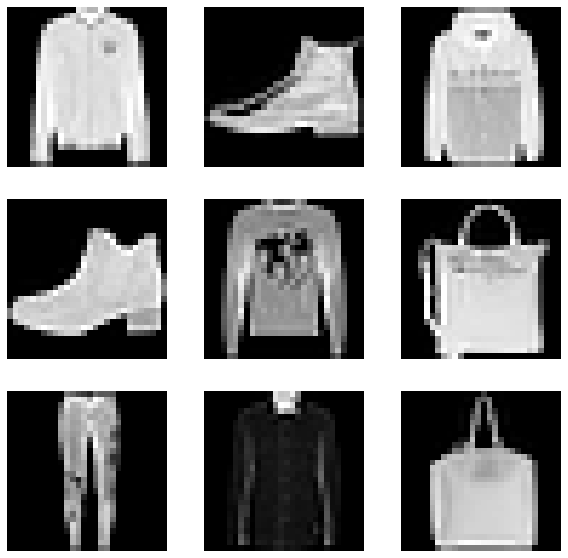

In [ ]:
plt.figure(figsize=(10, 10))
for images in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype(dtype=np.float32), cmap='gray')
    plt.axis("off")

In [ ]:
for image_batch in train_ds:
  print(image_batch.shape)
  break

(512, 28, 28, 1)


In [ ]:
def make_generator_model(rand_len):
    model = tf.keras.Sequential()
    model.add(Dense(7*7*16,input_shape=(rand_len,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))
    
    model.add(Reshape((7, 7, 16)))
    
    model.add(Conv2DTranspose(128, (3, 3), strides=(1, 1), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))


    model.add(Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))

    model.add(Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))


    model.add(Conv2DTranspose(1, (3, 3), strides=(1, 1), padding='same', activation='sigmoid'))
    return model

In [ ]:
#Ref : https://stackoverflow.com/questions/42264567/keras-ml-library-how-to-do-weight-clipping-after-gradient-updates-tensorflow-b
class weight_clip(keras.constraints.Constraint):
    def __init__(self, c=0.01):
        self.c = c

    def __call__(self, p):
        return tf.clip_by_value(p, -self.c, self.c)

    def get_config(self):
        return {'name': self.__class__.__name__,
                'c': self.c}

constraint = weight_clip()

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(Conv2D(32, (3, 3), strides=(1, 1), input_shape=[28, 28, 1], kernel_constraint=constraint, bias_constraint=constraint ))
    model.add(LeakyReLU(0.2))
    
    
    model.add(Conv2D(64, (3, 3), strides=(2, 2), kernel_constraint=constraint, bias_constraint=constraint))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(16, (3, 3), strides=(2, 2), kernel_constraint=constraint, bias_constraint=constraint))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))
    

    model.add(Conv2D(8, (3, 3), strides=(2, 2), kernel_constraint=constraint, bias_constraint=constraint))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))

    model.add(Flatten())
    model.add(Dense(1, kernel_constraint=constraint, bias_constraint=constraint))

    return model

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    mean_fake_output = tf.reduce_mean(fake_output)
    return -1 * mean_fake_output

def discriminator_loss(real_output, fake_output):
    return tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1= 0.6)
discriminator_optimizer = tf.keras.optimizers.Adam(5e-5, beta_1= 0.4)

In [ ]:
generator = make_generator_model(random_length)
discriminator = make_discriminator_model()

In [ ]:
#@tf.function
def train_step(images, batch, noise_dim):
    for i in range(3):
        noise = tf.random.normal([batch, noise_dim])
        with tf.GradientTape() as disc_tape:
          generated_images = generator(noise, training=True)

          real_output = discriminator(images, training=True)
          fake_output = discriminator(generated_images, training=True)
          disc_loss = discriminator_loss(real_output, fake_output) 
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
        #discriminator.set_weights(list(map(lambda x: tf.clip_by_value(x, -0.01, 0.01),discriminator.get_weights())))
    
    for i in range(1):
        noise_new = tf.random.normal([batch, noise_dim])
        with tf.GradientTape() as gen_tape:
          generated_images_new = generator(noise_new, training=True)
          fake_output_new = discriminator(generated_images_new, training=True)
          gen_loss = generator_loss(fake_output_new)
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    return disc_loss, gen_loss

In [ ]:
def dispaly_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(15, 15))

  for i in range(predictions.shape[0]):
      plt.subplot(8, 8, i+1)
      plt.imshow(predictions[i], cmap='gray')
      plt.axis('off')
  plt.show()

Discriminator loss is tf.Tensor(-0.21722184, shape=(), dtype=float32)
Generator loss is tf.Tensor(0.06507639, shape=(), dtype=float32)
Time for epoch 100 is 23.17 sec


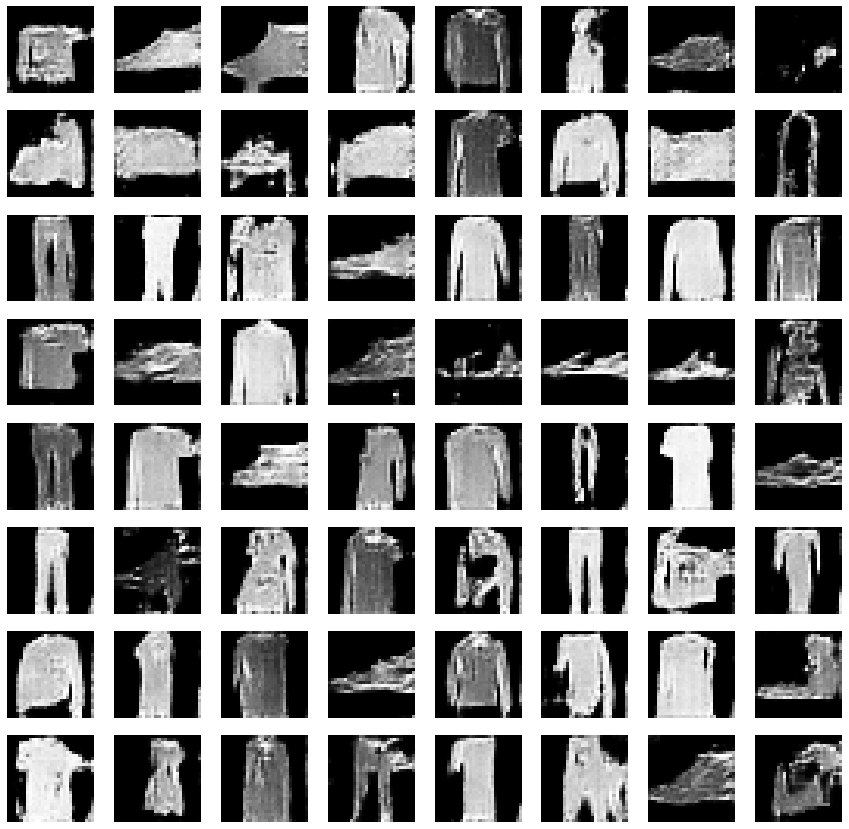

In [ ]:
epochs = 100
with tf.device('/device:GPU:3'):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in train_ds:
          disc_loss, gen_loss = train_step(image_batch, tf.shape(image_batch)[0], random_length)

        if (epoch +1)%2 == 0:
          display.clear_output(wait=True)
          print("Discriminator loss is", disc_loss)
          print("Generator loss is", gen_loss)
          print ('Time for epoch {} is {:.2f} sec'.format(epoch + 1, time.time()-start))
          dispaly_images(generator,
                             epoch + 1,
                             tf.random.normal([64, random_length]))

## WGAN-GP
---

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
os.chdir('/project/ardas/LGM/GAN')

In [ ]:
def make_generator_model(rand_len):
    model = tf.keras.Sequential()
    model.add(Dense(7*7*16,input_shape=(rand_len,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))
    
    model.add(Reshape((7, 7, 16)))
    
    model.add(Conv2DTranspose(128, (3, 3), strides=(1, 1), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))


    model.add(Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))

    model.add(Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))


    model.add(Conv2DTranspose(1, (3, 3), strides=(1, 1), padding='same', activation='sigmoid'))
    return model

In [ ]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(Conv2D(32, (3, 3), strides=(1, 1), input_shape=[28, 28, 1]))
    model.add(LeakyReLU(0.2))

    
    model.add(Conv2D(64, (3, 3), strides=(2, 2), padding='valid'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))


    model.add(Conv2D(16, (3, 3), strides=(2, 2)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))
    
    model.add(Conv2D(8, (3, 3), strides=(1, 1)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))

    model.add(Flatten())
    model.add(Dense(1))

    return model

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return -1 * tf.reduce_mean(fake_output)

def discriminator_loss(real_output, fake_output):
    return tf.reduce_mean(fake_output) - tf.reduce_mean(real_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1= 0.5, beta_2=0.9)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1= 0.5, beta_2=0.9)

In [ ]:
generator = make_generator_model(random_length)
discriminator = make_discriminator_model()

In [ ]:
#@tf.function
def train_step(images, batch, noise_dim):
    for i in range(3):
        noise = tf.random.normal([batch, noise_dim])
        with tf.GradientTape() as disc_tape:
          generated_images = generator(noise, training=False)

          real_output = discriminator(images, training=True)
          fake_output = discriminator(generated_images, training=True)
          alpha = tf.random.uniform(
                    shape=[batch,1,1,1], 
                    minval=0.,
                    maxval=1.)
          interpolates = alpha*images + (1-alpha)*generated_images
          with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolates)
            ip_out = discriminator(interpolates)
          gradients = gp_tape.gradient(ip_out, interpolates)
          slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=[1, 2]))
          gradient_penalty = tf.reduce_mean((slopes-1.)**2)
          disc_loss = discriminator_loss(real_output, fake_output) + 10.*gradient_penalty
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    for i in range(1):
        noise_new = tf.random.normal([batch, noise_dim])
        with tf.GradientTape() as gen_tape:
          generated_images_new = generator(noise_new, training=True)
          fake_output_new = discriminator(generated_images_new, training=True)
          gen_loss = generator_loss(fake_output_new)
        gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    return disc_loss, gen_loss

In [ ]:
def dispaly_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(15, 15))

  for i in range(predictions.shape[0]):
      plt.subplot(8, 8, i+1)
      plt.imshow(predictions[i],cmap='gray')
      plt.axis('off')
  plt.show()

Discriminator loss is tf.Tensor(-2.1671498, shape=(), dtype=float32)
Generator loss is tf.Tensor(2.722173, shape=(), dtype=float32)
Time for epoch 60 is 20.22 sec


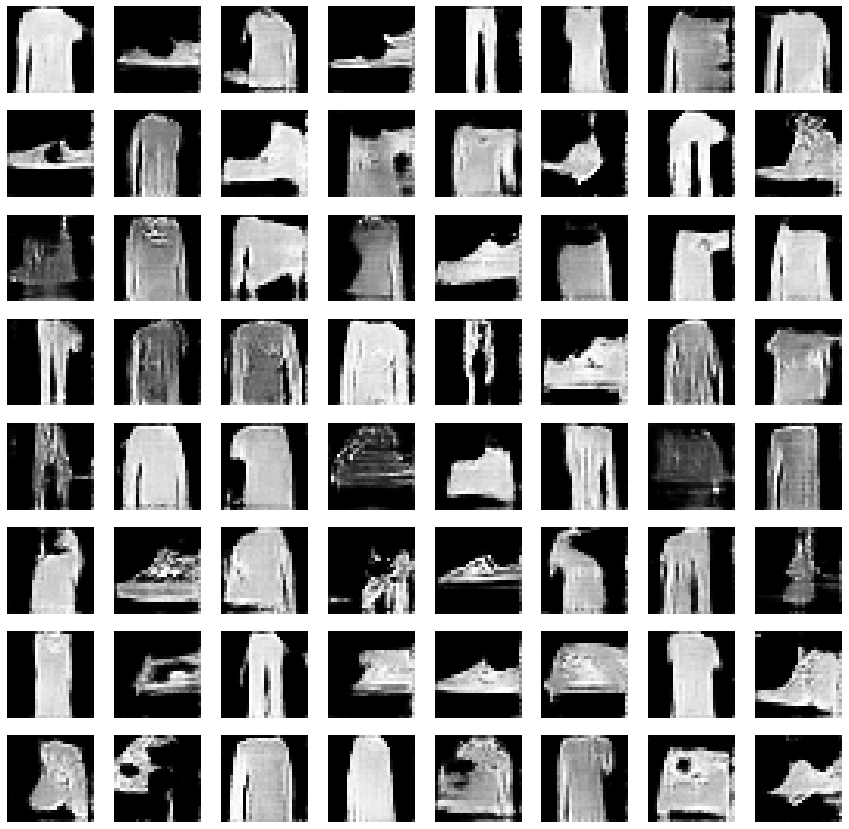

In [ ]:
epochs = 60
with tf.device('/device:GPU:2'):
    for epoch in range(epochs):
        start = time.time()

        for image_batch in train_ds:
          disc_loss, gen_loss = train_step(image_batch, tf.shape(image_batch)[0], random_length)

        if (epoch +1)%2 == 0:
          display.clear_output(wait=True)
          print("Discriminator loss is", disc_loss)
          print("Generator loss is", gen_loss)
          print ('Time for epoch {} is {:.2f} sec'.format(epoch + 1, time.time()-start))
          dispaly_images(generator,
                             epoch + 1,
                             tf.random.normal([64, random_length]))